# Batch mode script to call and run the pipeline

In [ ]:
# Install ipywidgets,ipyevents, circlefit and mayavi
!pip install ipywidgets
!pip install ipyevents 
!pip install mayavi
!pip install circle-fit

In [1]:
# Import dependencies
import nibabel as nib
import numpy as np
import cv2
import scipy.io
import os
import imageio
import circle_fit as cf
from utils import euclidean_distance_coords
from tabulate import tabulate

# Create list of subfolders - names of patient files to run the batch mode on
subfolders = next(os.walk(os.path.join('data')))[1]
subfolders = ['DBS_bG56', 'DBS_bG64', 'DBS_bT20']
print(subfolders)

['DBS_bG56', 'DBS_bG64', 'DBS_bT20']


fluoro_segmentation.py successfully executed.


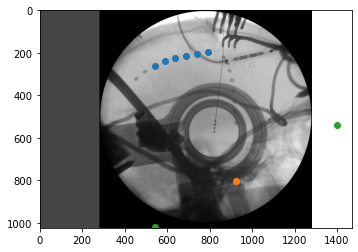

C:\Users\Micah Vinet\OneDrive\Documents\BrainReg\BrainReg-main\ct_segmentation.py:36: RuntimeWarning: invalid value encountered in true_divide
  img = (img - np.min(img)) / (np.max(img) - np.min(img))
C:\Users\Micah Vinet\OneDrive\Documents\BrainReg\BrainReg-main\ct_segmentation.py:79: RuntimeWarning: invalid value encountered in true_divide
  img = (img - np.min(img)) / (np.max(img) - np.min(img))


ct_segmentation.py successfully executed.
Notebook initialized with ipy backend.
fluoro_ct_alignment.py successfully executed.
[[ 35.57836118  27.26025084]
 [ 51.67354557  30.64595602]
 [ 69.2721686   35.28709698]
 [107.10160753  47.95199627]
 [ 22.59171695  26.94445493]
 [ 87.37605422  40.76899347]]


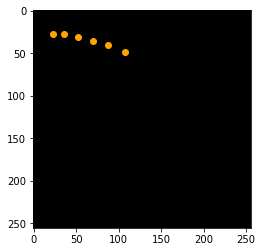

hull_projection.py executed succesfully
[array([40.54407811, 32.19973973, 30.82957274]), array([43.54407815, 28.19973968, 30.82957278]), array([44.5440778 , 22.19973964, 33.82957315]), array([55.54407927, -0.80026054, 29.82957281]), array([39.54407826, 34.19973976, 29.82957261]), array([51.54407878, 12.19973954, 29.82957275])]


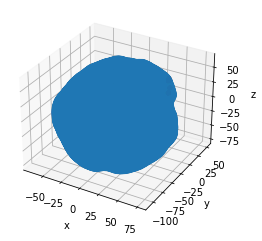

The predicted ECoG (x,y,z) coordinates are
[[40.54407811 32.19973973 30.82957274]
 [43.54407815 28.19973968 30.82957278]
 [44.5440778  22.19973964 33.82957315]
 [55.54407927 -0.80026054 29.82957281]
 [39.54407826 34.19973976 29.82957261]
 [51.54407878 12.19973954 29.82957275]]
and the ground truth ECoG (x,y,z) coordinates are
[[60.54408517  0.1997396  -0.17043073]
 [59.54408362 -0.80026044  7.82957021]
 [59.54408206 -2.80026051 15.82957117]
 [57.54408062 -4.80026053 23.82957211]
 [55.54407939 -6.80026055 30.82957294]
 [51.54407834 -9.80026053 37.82957375]]
for patient
DBS_bG56
fluoro_segmentation.py successfully executed.


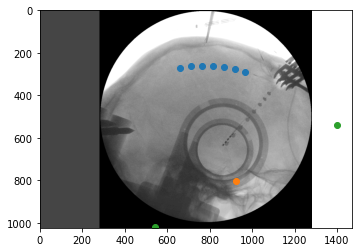

C:\Users\Micah Vinet\OneDrive\Documents\BrainReg\BrainReg-main\ct_segmentation.py:36: RuntimeWarning: invalid value encountered in true_divide
  img = (img - np.min(img)) / (np.max(img) - np.min(img))
C:\Users\Micah Vinet\OneDrive\Documents\BrainReg\BrainReg-main\ct_segmentation.py:79: RuntimeWarning: invalid value encountered in true_divide
  img = (img - np.min(img)) / (np.max(img) - np.min(img))


ct_segmentation.py successfully executed.
Notebook initialized with ipy backend.
fluoro_ct_alignment.py successfully executed.
[[230.1066284  107.6613039 ]
 [192.19133438  95.09962614]
 [222.78008175 102.8188873 ]
 [199.97735671  94.95066159]
 [215.3788624   98.92934711]
 [207.74050553  96.33852165]
 [237.00674292 113.60500092]]


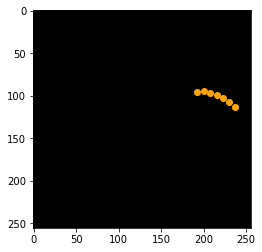

hull_projection.py executed succesfully
[array([ 56.73311615, -81.94378662,   0.6616745 ]), array([ 60.73311615, -69.94378662,   3.6616745 ]), array([ 56.73311615, -81.94378662,   0.6616745 ]), array([ 60.73311615, -69.94378662,   3.6616745 ]), array([ 58.73311615, -76.94378662,   2.6616745 ]), array([ 58.73311615, -75.94378662,   3.6616745 ]), array([ 55.73311615, -83.94378662,  -2.3383255 ])]


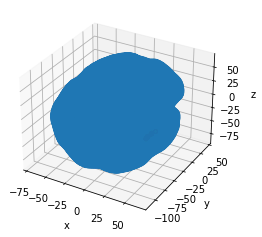

The predicted ECoG (x,y,z) coordinates are
[[ 56.73311615 -81.94378662   0.6616745 ]
 [ 60.73311615 -69.94378662   3.6616745 ]
 [ 56.73311615 -81.94378662   0.6616745 ]
 [ 60.73311615 -69.94378662   3.6616745 ]
 [ 58.73311615 -76.94378662   2.6616745 ]
 [ 58.73311615 -75.94378662   3.6616745 ]
 [ 55.73311615 -83.94378662  -2.3383255 ]]
and the ground truth ECoG (x,y,z) coordinates are
[[ 22.73311615 -40.94378662  55.6616745 ]
 [ 23.73311615 -48.94378662  52.6616745 ]
 [ 24.73311615 -56.94378662  48.6616745 ]
 [ 29.73311615 -63.94378662  42.6616745 ]
 [ 38.73311615 -69.94378662  37.6616745 ]
 [ 38.73311615 -77.94378662  31.6616745 ]
 [ 38.73311615 -82.94378662  24.6616745 ]]
for patient
DBS_bG64
fluoro_segmentation.py successfully executed.


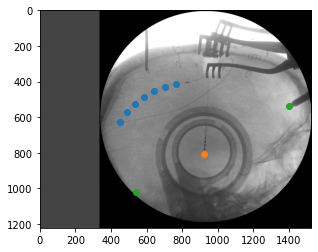

C:\Users\Micah Vinet\OneDrive\Documents\BrainReg\BrainReg-main\ct_segmentation.py:36: RuntimeWarning: invalid value encountered in true_divide
  img = (img - np.min(img)) / (np.max(img) - np.min(img))
C:\Users\Micah Vinet\OneDrive\Documents\BrainReg\BrainReg-main\ct_segmentation.py:79: RuntimeWarning: invalid value encountered in true_divide
  img = (img - np.min(img)) / (np.max(img) - np.min(img))


ct_segmentation.py successfully executed.
Notebook initialized with ipy backend.
fluoro_ct_alignment.py successfully executed.
[[144.6814785   39.19148899]
 [153.42870398  32.7135256 ]
 [188.73469768  34.79822049]
 [196.73439061  42.09407757]
 [162.45958932  28.24502341]
 [171.40955854  27.30055904]
 [180.2542547   29.51517256]]


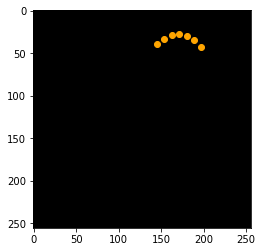

hull_projection.py executed succesfully
[array([ 58.88512421, -16.83932495,  33.71887207]), array([ 56.88512421, -23.83932495,  36.71887207]), array([ 57.88512421, -46.83932495,  32.71887207]), array([ 58.88512421, -48.83932495,  30.71887207]), array([ 53.88512421, -23.83932495,  40.71887207]), array([ 55.88512421, -32.83932495,  36.71887207]), array([ 57.88512421, -46.83932495,  32.71887207])]


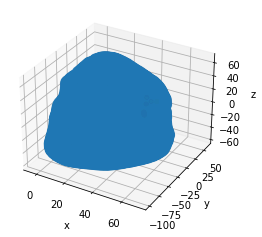

The predicted ECoG (x,y,z) coordinates are
[[ 58.88512421 -16.83932495  33.71887207]
 [ 56.88512421 -23.83932495  36.71887207]
 [ 57.88512421 -46.83932495  32.71887207]
 [ 58.88512421 -48.83932495  30.71887207]
 [ 53.88512421 -23.83932495  40.71887207]
 [ 55.88512421 -32.83932495  36.71887207]
 [ 57.88512421 -46.83932495  32.71887207]]
and the ground truth ECoG (x,y,z) coordinates are
[[ 48.88512421 -73.83932495  21.71887207]
 [ 45.88512421 -68.83932495  28.71887207]
 [ 44.88512421 -62.83932495  34.71887207]
 [ 44.88512421 -55.83932495  40.71887207]
 [ 45.88512421 -47.83932495  44.71887207]
 [ 42.88512421 -39.83932495  47.71887207]
 [ 39.88512421 -31.83932495  50.71887207]]
for patient
DBS_bT20


In [2]:
# Load data, execute pipeline, and display outputs in batch for each inputted patient file name
data = []
for i in range(len(subfolders)):

    # Load patient data
    SAMPLE_NAME = subfolders[i]
    HULL_FILE_NAME = os.path.join('data/' + SAMPLE_NAME,"hull_rh.mat")
    PRECT_FILE_NAME = os.path.join('data/' + SAMPLE_NAME,"preop_ct.nii")
    POSTCT_FILE_NAME = os.path.join('data/' + SAMPLE_NAME,"postop_ct.nii")
    FLUORO_FILE_NAME = os.path.join('data/' + SAMPLE_NAME,"fluoro.tif")

    # read .mat File
    hull = scipy.io.loadmat(HULL_FILE_NAME)
    points_hull=np.array(hull['mask_indices'])

    #read pre op CT
    prect = nib.load(PRECT_FILE_NAME)
    prect_data = np.nan_to_num(np.array(prect.get_fdata()))
    Tmatrix = np.transpose(prect.affine)

    #read post op CT
    postct = nib.load(POSTCT_FILE_NAME)
    postct_data = np.nan_to_num(np.array(postct.get_fdata()))

    # fourth channel is infrared
    fluoro = imageio.imread(FLUORO_FILE_NAME)
    fluoro = cv2.cvtColor(fluoro, cv2.COLOR_BGR2GRAY)

    #Call main script to run all component scripts for this patient and display results to user
    %run Pipeline.ipynb
    
    #Load ground truth coordinates
    gt_dict = scipy.io.loadmat(os.path.join('data/' + SAMPLE_NAME + "/electrode_locations/electrode_locs.mat"))
    gt = gt_dict['CortElecLoc']
    gt = np.concatenate(gt,axis=0)
    new_gt = []
    for i in range (len(gt)):
        new = np.concatenate(gt[i],axis = 0)
        new_gt.append(new)
    new_gt = np.array(new_gt)
    new_gt = new_gt[0:len(predictions),:]
    
    #Append results from this patient
    data.append(SAMPLE_NAME)
    data.append(predictions)
    data.append(new_gt)
    data.append(np.mean(np.abs(new_gt - predictions)))
    data.append(euclidean_distance_coords(predictions, new_gt))
    
    #Display values of predicted and ground truth electrode coordinates
    print('The predicted ECoG (x,y,z) coordinates are')
    print(predictions)
    print('and the ground truth ECoG (x,y,z) coordinates are')
    print(new_gt)
    print('for patient')
    print(SAMPLE_NAME)

data = list(data)

CT segmentation visualization 2

###  DBS_bG56

In [3]:
from IPython.display import Image
Image(url="https://drive.google.com/uc?export=view&id=1H6GJcnixafTReEyp2a3ILdQ2NoY-ybgF")

###  DBS_bG64

In [4]:
Image(url="https://drive.google.com/uc?export=view&id=1BoxHu9nhSoy0TfDrxOMO6rIv4rezNuOR")

### DBSbT20

In [5]:
Image(url="https://drive.google.com/uc?export=view&id=10P3szX3SlnQ9UOII6OjdYEfI_Tsp4mru")

In [7]:
# Print results of batch to a table
patients = [data[0], data[5], data[10]]
predict = [data[1], data[6], data[11]]
ground = [data[2], data[7], data[12]]
MAE = [data[3], data[8], data[13]]
EucDist = [data[4], data[9], data[14]]

table = zip(patients,predict,ground,MAE,EucDist)

headers=["Patient", "Predicted", "Ground Truth", "MAE", "Euclidean Distance"]

print(tabulate(table,headers))

Patient    Predicted                                   Ground Truth                                    MAE    Euclidean Distance
---------  ------------------------------------------  ------------------------------------------  -------  --------------------
DBS_bG56   [[40.54407811 32.19973973 30.82957274]      [[60.54408517  0.1997396  -0.17043073]      17.1667               43.2466
            [43.54407815 28.19973968 30.82957278]       [59.54408362 -0.80026044  7.82957021]
            [44.5440778  22.19973964 33.82957315]       [59.54408206 -2.80026051 15.82957117]
            [55.54407927 -0.80026054 29.82957281]       [57.54408062 -4.80026053 23.82957211]
            [39.54407826 34.19973976 29.82957261]       [55.54407939 -6.80026055 30.82957294]
            [51.54407878 12.19973954 29.82957275]]      [51.54407834 -9.80026053 37.82957375]]
DBS_bG64   [[ 56.73311615 -81.94378662   0.6616745 ]   [[ 22.73311615 -40.94378662  55.6616745 ]   27.381                75.325
            [ 